In [1]:
import os
import sys
import string 

import pandas as pd
import numpy as np
import random
import itertools

from matplotlib import pyplot as plt

from tqdm import tqdm

from pandarallel import pandarallel

import pymorphy2
import nltk
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from keras.preprocessing.sequence import pad_sequences

import gensim
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.phrases import Phrases, Phraser

import time

sys.path.append("..")
from src import *

SEED = 1
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True
init_random_seed(SEED)
    
pd.set_option('display.max_colwidth', 255)
tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=8, use_memory_fs=False)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
abbr = pd.read_csv("../data/abbr.csv")
lenta_train = pd.read_csv("../data/lenta_train.csv")
lenta_test = pd.read_csv("../data/lenta_test.csv")

In [3]:
id2abbr = {}
abbr2id = {}
id2desc = {}
desc2id = {}
for idx, abbr_name, desc in abbr[["abbr_id", "abbr_norm", "desc_norm"]].values:
    id2abbr[idx] = abbr_name
    abbr2id[abbr_name] = idx
    id2desc[idx] = desc
    desc2id[desc] = idx

In [4]:
lenta_train["labels_new"] = (
    lenta_train["labels_new"].str.replace("W", "")
                            .str.replace("B", "")
                            .str.replace("E", "")
                            .str.replace("-", "")
)
train_texts = list(map(lambda x: x.split(" "), lenta_train["text_new"].to_list()))
train_labels = list(map(lambda x: x.split(" "), lenta_train["labels_new"].to_list()))

lenta_test["labels_new"] = (
    lenta_test["labels_new"].str.replace("W", "")
                            .str.replace("B", "")
                            .str.replace("E", "")
                            .str.replace("-", "")
)
test_texts = list(map(lambda x: x.split(" "), lenta_test["text_new"].to_list()))
test_labels = list(map(lambda x: x.split(" "), lenta_test["labels_new"].to_list()))

In [5]:
PAD_TOKEN = "<PAD>"
PAD_TOKEN_ID = 0

PAD_LABEL = "<NOLABEL>"
PAD_LABEL_ID = 0

EMPTY_LABEL = "_"
EMPTY_LABEL_ID = 1

train_texts_global = list(itertools.chain(*train_texts))
train_labels_global = list(itertools.chain(*train_labels))
train_labels_global = list(filter(lambda x: x != EMPTY_LABEL, train_labels_global))

UNIQUE_TOKENS = [PAD_TOKEN] + list(set(train_texts_global))
UNIQUE_LABELS = [PAD_LABEL, EMPTY_LABEL] + list(set(train_labels_global))

token2id = {label: i for i, label in enumerate(UNIQUE_TOKENS)}
id2token = {i: label for label, i in token2id.items()}

label2id = {label: i for i, label in enumerate(UNIQUE_LABELS)}
id2label = {i: label for label, i in label2id.items()}

MAX_SENTENCE_LEN = lenta_train.text_new.str.split(" ").str.len().max()
train_size = len(train_texts)
test_size = len(test_texts)
TOKENS_NUM = len(UNIQUE_TOKENS)
LABELS_NUM = len(UNIQUE_LABELS)

print(MAX_SENTENCE_LEN, train_size, test_size, TOKENS_NUM, LABELS_NUM)

282 403411 100853 635711 1162


## 3. Обучение модели на n-граммах 

In [6]:
connector_words = nltk.corpus.stopwords.words("russian")
phrase_model = Phrases(
    train_texts, 
    min_count=5, 
    threshold=10,
    connector_words=connector_words
).freeze()

In [12]:
class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''

    def __init__(self, verbose: int = 1):
        self.epoch = 0
        self.verbose = verbose
        self.start_sec = int(time.time())
        self.last_loss = None
        
    def on_epoch_end(self, model):
        if self.epoch % self.verbose == 0:
            loss = model.get_latest_training_loss()
            
            end_sec = int(time.time())
            diff_sec = end_sec - self.start_sec
            self.start_sec = end_sec
            
            if self.last_loss == None:
                self.last_loss = loss
            
            print(f'Epoch {self.epoch}, loss {loss - self.last_loss}, sec {diff_sec}\n')
            
            self.last_loss = loss
        self.epoch += 1



In [7]:
epoch_logger = EpochLogger(verbose=1)

model = gensim.models.Word2Vec(
    sentences=phrase_model[train_texts], 
    vector_size=64, window=5, min_count=5, workers=16,
    sg=1, epochs=20, callbacks=[epoch_logger], compute_loss=True)

Epoch 0, loss 0.0, sec 102

Epoch 1, loss 15403634.0, sec 50

Epoch 2, loss 14324600.0, sec 49

Epoch 3, loss 6961208.0, sec 49

Epoch 4, loss 921120.0, sec 50

Epoch 5, loss 961744.0, sec 49

Epoch 6, loss 993240.0, sec 50

Epoch 7, loss 1010928.0, sec 49

Epoch 8, loss 983336.0, sec 50

Epoch 9, loss 976288.0, sec 50

Epoch 10, loss 991184.0, sec 50

Epoch 11, loss 901208.0, sec 49

Epoch 12, loss 981472.0, sec 50

Epoch 13, loss 950008.0, sec 49

Epoch 14, loss 989288.0, sec 50

Epoch 15, loss 927800.0, sec 49

Epoch 16, loss 976680.0, sec 50

Epoch 17, loss 933016.0, sec 49

Epoch 18, loss 978136.0, sec 49

Epoch 19, loss 870160.0, sec 50



In [15]:
history = []

for emb_size in [16, 32, 64, 128]:
    print("START ", emb_size)

    epoch_logger = EpochLogger(verbose=1)

    model = gensim.models.Word2Vec(
        sentences=phrase_model[train_texts], 
        vector_size=emb_size, window=5, min_count=5, workers=16,
        sg=1, epochs=10, callbacks=[epoch_logger], compute_loss=True)
    
    
    token2desc = get_token2desc(tokens=list(token2id.keys()), 
                                w2v_model=model, 
                                desc2id=desc2id, 
                                topn=1, 
                                dist=lev_dist)

    preds = []
    for text in tqdm(test_texts):
        labels = []
        for word in text:
            if word in token2desc:
                label = token2desc[word]  
            else:
                label = "_"
            labels.append(str(label))
        preds.append(labels)

    test_labels_global = list(itertools.chain(*test_labels))
    test_preds_global = list(itertools.chain(*preds))

    test_labels_global_upd = []
    for label_id in test_labels_global:
        if label_id == "_":
            test_labels_global_upd.append("_")
        else:
            test_labels_global_upd.append(id2desc.get(int(label_id), "_"))

    test_preds_global_upd = []
    for label_id in test_preds_global:
        if label_id == "_":
            test_preds_global_upd.append("_")
        else:
            test_preds_global_upd.append(id2desc.get(int(label_id), "_"))

    f1 = f1_score(test_labels_global_upd, test_preds_global_upd, average="macro")
    filtred_acc = get_filtred_accuracy_score(test_labels_global_upd, test_preds_global_upd)
    print(f1, filtred_acc)
    print()

    history.append((emb_size, f1, filtred_acc))

START  16
Epoch 0, loss 0.0, sec 84

Epoch 1, loss 15347640.0, sec 50

Epoch 2, loss 13160452.0, sec 50

Epoch 3, loss 7692980.0, sec 50

Epoch 4, loss 942680.0, sec 49

Epoch 5, loss 928768.0, sec 49

Epoch 6, loss 948728.0, sec 50

Epoch 7, loss 877888.0, sec 48

Epoch 8, loss 940808.0, sec 50

Epoch 9, loss 932288.0, sec 49



100%|██████████| 100853/100853 [00:05<00:00, 19067.52it/s]


0.15811258105829964 0.4593936677459989

START  32
Epoch 0, loss 0.0, sec 100

Epoch 1, loss 15353682.0, sec 50

Epoch 2, loss 14150764.0, sec 49

Epoch 3, loss 7271124.0, sec 49

Epoch 4, loss 912688.0, sec 49

Epoch 5, loss 972456.0, sec 46

Epoch 6, loss 914040.0, sec 49

Epoch 7, loss 947072.0, sec 47

Epoch 8, loss 915232.0, sec 47

Epoch 9, loss 833392.0, sec 48



100%|██████████| 100853/100853 [00:03<00:00, 32327.19it/s]


0.19763814254354556 0.5415514581201021

START  64
Epoch 0, loss 0.0, sec 83

Epoch 1, loss 16177460.0, sec 50

Epoch 2, loss 13351140.0, sec 50

Epoch 3, loss 6918460.0, sec 50

Epoch 4, loss 852720.0, sec 50

Epoch 5, loss 796352.0, sec 49

Epoch 6, loss 882136.0, sec 50

Epoch 7, loss 847936.0, sec 51

Epoch 8, loss 845032.0, sec 52

Epoch 9, loss 834840.0, sec 51



100%|██████████| 100853/100853 [00:05<00:00, 19125.82it/s]


0.20836923994191506 0.564756926136278

START  128
Epoch 0, loss 0.0, sec 109

Epoch 1, loss 15458228.0, sec 60

Epoch 2, loss 14235380.0, sec 61

Epoch 3, loss 6751872.0, sec 62

Epoch 4, loss 885048.0, sec 60

Epoch 5, loss 857480.0, sec 58

Epoch 6, loss 821448.0, sec 59

Epoch 7, loss 879640.0, sec 59

Epoch 8, loss 807984.0, sec 58

Epoch 9, loss 759768.0, sec 59



100%|██████████| 100853/100853 [00:05<00:00, 19123.73it/s]


0.21839714908340602 0.563977436512756



In [16]:
for emb_size in [4, 8, 256, 64]:
    print("START ", emb_size)

    epoch_logger = EpochLogger(verbose=1)

    model = gensim.models.Word2Vec(
        sentences=phrase_model[train_texts], 
        vector_size=emb_size, window=5, min_count=5, workers=16,
        sg=1, epochs=10, callbacks=[epoch_logger], compute_loss=True)
    
    
    token2desc = get_token2desc(tokens=list(token2id.keys()), 
                                w2v_model=model, 
                                desc2id=desc2id, 
                                topn=1, 
                                dist=lev_dist)

    preds = []
    for text in tqdm(test_texts):
        labels = []
        for word in text:
            if word in token2desc:
                label = token2desc[word]  
            else:
                label = "_"
            labels.append(str(label))
        preds.append(labels)

    test_labels_global = list(itertools.chain(*test_labels))
    test_preds_global = list(itertools.chain(*preds))

    test_labels_global_upd = []
    for label_id in test_labels_global:
        if label_id == "_":
            test_labels_global_upd.append("_")
        else:
            test_labels_global_upd.append(id2desc.get(int(label_id), "_"))

    test_preds_global_upd = []
    for label_id in test_preds_global:
        if label_id == "_":
            test_preds_global_upd.append("_")
        else:
            test_preds_global_upd.append(id2desc.get(int(label_id), "_"))

    f1 = f1_score(test_labels_global_upd, test_preds_global_upd, average="macro")
    filtred_acc = get_filtred_accuracy_score(test_labels_global_upd, test_preds_global_upd)
    print(f1, filtred_acc)
    print()

    if emb_size != 64:
        history.append((emb_size, f1, filtred_acc))

START  4
Epoch 0, loss 0.0, sec 95

Epoch 1, loss 14860532.0, sec 46

Epoch 2, loss 14132004.0, sec 46

Epoch 3, loss 4805120.0, sec 46

Epoch 4, loss 534032.0, sec 46

Epoch 5, loss 563432.0, sec 46

Epoch 6, loss 579336.0, sec 46

Epoch 7, loss 559768.0, sec 46

Epoch 8, loss 585416.0, sec 47

Epoch 9, loss 599784.0, sec 46



100%|██████████| 100853/100853 [00:05<00:00, 19326.75it/s]


0.004563271042682455 0.019653498559532735

START  8
Epoch 0, loss 0.0, sec 97

Epoch 1, loss 14960244.0, sec 46

Epoch 2, loss 14214588.0, sec 46

Epoch 3, loss 5777972.0, sec 45

Epoch 4, loss 779096.0, sec 45

Epoch 5, loss 808408.0, sec 47

Epoch 6, loss 835688.0, sec 49

Epoch 7, loss 830456.0, sec 48

Epoch 8, loss 850040.0, sec 48

Epoch 9, loss 842536.0, sec 48



100%|██████████| 100853/100853 [00:05<00:00, 19500.49it/s]


0.08322071635055155 0.41161463422199474

START  256
Epoch 0, loss 0.0, sec 130

Epoch 1, loss 15939740.0, sec 80

Epoch 2, loss 14564240.0, sec 83

Epoch 3, loss 6217860.0, sec 78

Epoch 4, loss 785600.0, sec 78

Epoch 5, loss 872352.0, sec 79

Epoch 6, loss 774744.0, sec 78

Epoch 7, loss 752008.0, sec 78

Epoch 8, loss 774984.0, sec 80

Epoch 9, loss 742872.0, sec 78



100%|██████████| 100853/100853 [00:03<00:00, 30769.05it/s]


0.2233363968809249 0.5771891171798944

START  64
Epoch 0, loss 0.0, sec 84

Epoch 1, loss 16083580.0, sec 51

Epoch 2, loss 14405784.0, sec 51

Epoch 3, loss 6180076.0, sec 51

Epoch 4, loss 894544.0, sec 51

Epoch 5, loss 889936.0, sec 52

Epoch 6, loss 906080.0, sec 51

Epoch 7, loss 899232.0, sec 51

Epoch 8, loss 872120.0, sec 51

Epoch 9, loss 827376.0, sec 50



100%|██████████| 100853/100853 [00:03<00:00, 32427.77it/s]


0.21449809354833874 0.5693278103472993



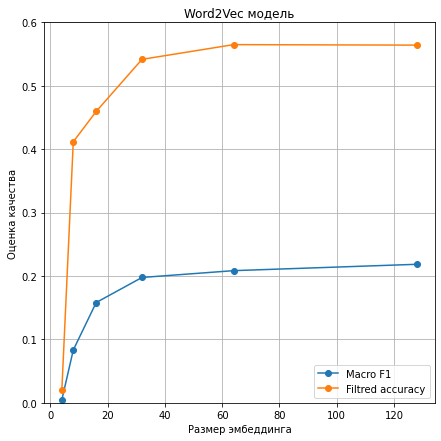

In [43]:
w2v_history = (
    pd.DataFrame(history, columns=["emb_size", "f1", "acc"])
        .sort_values("emb_size")
)
w2v_history = data[data.emb_size != 256]
w2v_history.to_csv("../logs/w2v_history.csv", index=False)

plt.figure(figsize=(7, 7))
plt.plot(w2v_history.emb_size, w2v_history.f1, "o-", label="Macro F1")
plt.plot(w2v_history.emb_size, w2v_history.acc, "o-", label="Filtred accuracy")
plt.grid()
plt.title("Word2Vec модель")
plt.xlabel("Размер эмбеддинга")
plt.ylabel("Оценка качества")
plt.legend()
plt.ylim(0, 0.6)
plt.show()

In [41]:
model_name = os.path.join("../models/w2v", "emb_64.word2vec")
model.save(model_name)
# model = gensim.models.Word2Vec.load(model_name)

In [7]:
def lev_dist(a, b):
    a, b = list(a), list(b)
    def recursive(i, j):
        if i == 0 or j == 0:
            return max(i, j)
        elif a[i - 1] == b[j - 1]:
            return recursive(i - 1, j - 1)
        else:
            return 1 + min(
                recursive(i, j - 1),
                recursive(i - 1, j),
                recursive(i - 1, j - 1)
            )
    return recursive(len(a), len(b))

def intersection_dist(a, b):
    a, b = set(a), set(b)
    max_intersection_len = min(len(a), len(b))
    return max_intersection_len - len(a.intersection(b))

def prefix_dist(a, b):
    max_i = 0
    for i in range(len(a)):
        if a[:i] in b:
            max_i = max(i + 1, max_i)
    return len(a) - max_i

def get_desc_find_by_dist(word, w2v_model, topn=5, dist=prefix_dist):
    desc_score_dist = []
    for desc, score in w2v_model.wv.most_similar(word, topn=topn):
        desc = desc.replace("_", " ")
        desc_score_dist.append([desc, score, dist(word, desc)])
    desc_score_dist = sorted(desc_score_dist, key=lambda x: x[2])
    return desc_score_dist[0][0]

In [8]:
def get_desc_first(word, w2v_model):
    first_desc = w2v_model.wv.most_similar(word, topn=1)[0][0]
    first_desc = first_desc.replace("_", " ")
    return first_desc

def get_desc_find_in_dict(word, w2v_model, desc2id):
    for desc, score in w2v_model.wv.most_similar(word, topn=10):
        desc = desc.replace("_", " ")
        if desc in desc2id.keys():
            return desc
        
    return get_desc_first(word, w2v_model)
        

def get_token2desc(tokens, w2v_model, desc2id, 
                   get_desc_f=get_desc_find_by_dist, topn=5, dist=intersection_dist):
    abbr_detection = AbbrDetection()

    token2desc = {}
    for token in tqdm(tokens):
        if abbr_detection.word_is_abbr(token):
            if token in w2v_model.wv.key_to_index:
                desc = get_desc_find_by_dist(token, w2v_model, 
                                             topn=topn, dist=intersection_dist)
                label = desc2id.get(desc, "_")
            else:
                label = "_"
        else:
            label = "_"
        token2desc[token] = label
    return token2desc
    

In [9]:
def get_filtred_accuracy_score(true, pred):
    stacked = zip(true, pred)
    filt_stacked = list(filter(lambda x: x != ("_", "_"), stacked))
    true, pred = zip(*filt_stacked)
    return accuracy_score(true, pred)

In [50]:
# history = []
for dist in [lev_dist]:
    for topn in [50]:
        print(dist.__name__, topn)
        token2desc = get_token2desc(tokens=list(token2id.keys()), 
                                    w2v_model=model, 
                                    desc2id=desc2id, 
                                    topn=topn, 
                                    dist=dist)

        preds = []
        for text in tqdm(test_texts):
            labels = []
            for word in text:
                if word in token2desc:
                    label = token2desc[word]  
                else:
                    label = "_"
                labels.append(str(label))
            preds.append(labels)

        test_labels_global = list(itertools.chain(*test_labels))
        test_preds_global = list(itertools.chain(*preds))

        test_labels_global_upd = []
        for label_id in test_labels_global:
            if label_id == "_":
                test_labels_global_upd.append("_")
            else:
                test_labels_global_upd.append(id2desc.get(int(label_id), "_"))

        test_preds_global_upd = []
        for label_id in test_preds_global:
            if label_id == "_":
                test_preds_global_upd.append("_")
            else:
                test_preds_global_upd.append(id2desc.get(int(label_id), "_"))

        f1 = f1_score(test_labels_global_upd, test_preds_global_upd, average="macro")
        filtred_acc = get_filtred_accuracy_score(test_labels_global_upd, test_preds_global_upd)
        print(f1, filtred_acc)
        
        history.append((dist.__name__, topn, f1, filtred_acc))

lev_dist 50


100%|██████████| 100853/100853 [00:03<00:00, 33518.34it/s]


0.231140125783379 0.5725673613105042


In [51]:
sorted(history, key=lambda x: x[3])

[('lev_dist', 100, 0.2290427316736635, 0.5632236901774647),
 ('lev_dist', 3, 0.2239110761990184, 0.5665723655082883),
 ('lev_dist', 1, 0.21449809354833874, 0.5693278103472993),
 ('lev_dist', 10, 0.22906289210868072, 0.5702157125438425),
 ('lev_dist', 30, 0.23004357488203375, 0.5724247873192403),
 ('lev_dist', 50, 0.231140125783379, 0.5725673613105042)]

In [52]:
history_df = pd.DataFrame(data=history, columns=["dist", "topn", "f1", "filtred_acc"])

In [53]:
import seaborn as sns

In [54]:
history_df

,dist,topn,f1,filtred_acc
0,lev_dist,1,0.214498,0.569328
1,lev_dist,3,0.223911,0.566572
2,lev_dist,10,0.229063,0.570216
3,lev_dist,30,0.230044,0.572425
4,lev_dist,100,0.229043,0.563224
5,lev_dist,50,0.231140,0.572567


In [57]:
history_df.sort_values("filtred_acc")

,dist,topn,f1,filtred_acc
4,lev_dist,100,0.229043,0.563224
1,lev_dist,3,0.223911,0.566572
0,lev_dist,1,0.214498,0.569328
2,lev_dist,10,0.229063,0.570216
3,lev_dist,30,0.230044,0.572425
5,lev_dist,50,0.231140,0.572567


<AxesSubplot:xlabel='topn', ylabel='filtred_acc'>

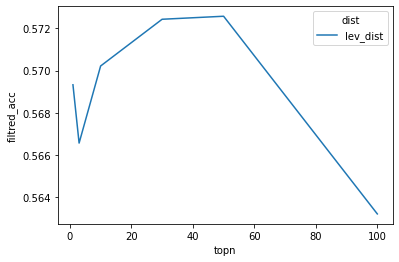

In [55]:
sns.lineplot(data=history_df, x="topn", y="filtred_acc", hue="dist")

In [73]:
print(classification_report(test_labels_global_upd, test_preds_global_upd))

/home/rv/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rv/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                          precision    recall  f1-score   support

                                                       _       1.00      1.00      1.00  22326537
                                                   абрам       1.00      1.00      1.00        32
                                              абсолютный       1.00      1.00      1.00       251
                                                  август       1.00      1.00      1.00      4879
                                авиационный безопасность       0.00      0.00      0.00        16
                                    авиационный комплекс       0.00      0.00      0.00        11
                                                 автобус       0.00      0.00      0.00       820
                                                 автомат       0.00      0.00      0.00       311
                                      автомат калашников       0.00      0.00      0.00        84
                   

/home/rv/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
